# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

np.random.seed(42)

In [2]:
df = pd.read_csv('data/human_body_temperature.csv')

### About the data set

#### Shape of the data

In [3]:
df.shape

(130, 3)

* Data cosists of 130 observations and 3 column variables. 

#### Look into first few observations

In [4]:
df.head(3)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0


#### Column Data Types

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


* Data consists of 3 columns - 2 of them are Numeric and the third is object. 
* There is no missing data. Every column has 130 entries
* Gender column can probably be changed to a category 

#### Statistical details of every column

In [6]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [7]:
df['gender'].describe()

count     130
unique      2
top         F
freq       65
Name: gender, dtype: object

* Gender does have only 2 unique values (65 M and 65 F). Hence can be changed into a category

#### Categorical Data

In [8]:
df['gender']=df['gender'].astype('category')

#### Checking for any outliers

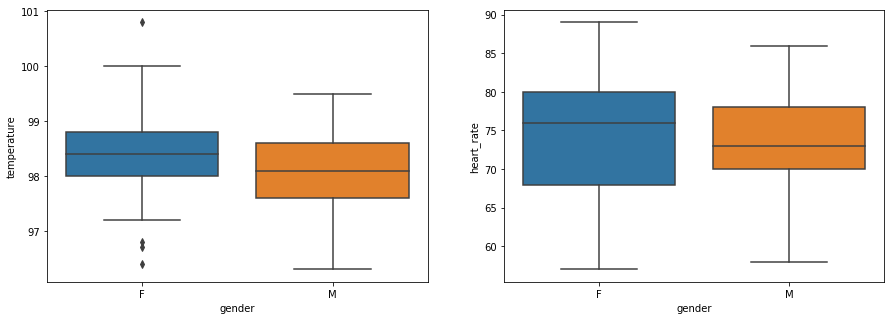

In [9]:
# Box plots of the numeric columns
f, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='gender', y='temperature', data = df, ax=axes[0])
sns.boxplot(x='gender', y='heart_rate', data = df, ax=axes[1])

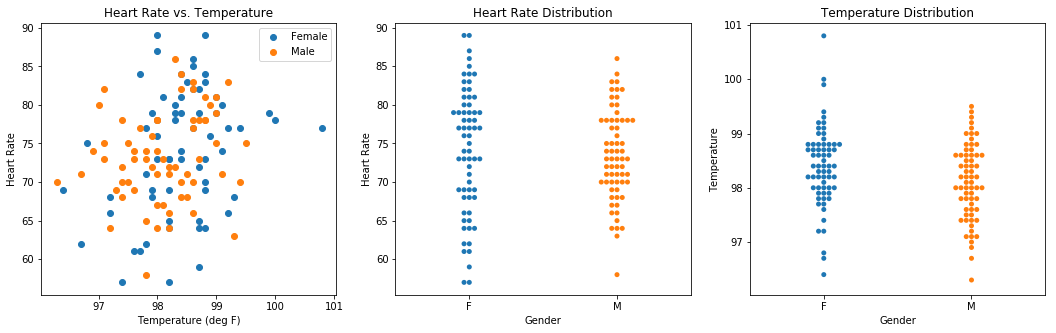

In [10]:
# Scatter and swarm plots 
f, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].scatter(df[df.gender=='F'].temperature, df[df.gender=='F'].heart_rate)
axes[0].scatter(df[df.gender=='M'].temperature, df[df.gender=='M'].heart_rate)
axes[0].set(title='Heart Rate vs. Temperature', xlabel='Temperature (deg F)', ylabel='Heart Rate')
axes[0].legend(('Female', 'Male'))
sns.swarmplot(x='gender', y='heart_rate', data = df, ax=axes[1])
axes[1].set(title='Heart Rate Distribution', xlabel='Gender', ylabel='Heart Rate')
sns.swarmplot(x='gender', y='temperature', data = df, ax=axes[2])
_ = axes[2].set(title='Temperature Distribution', xlabel='Gender', ylabel='Temperature')

**Observations**
* Female tends to have higher average body temperature and heart rate compared to Male
* There doesnt seem to be any correlation between Temperature and Heart Rate
* Higher spread/Larger variance in the Heart Rate in Female
* Box plot marks 4 outlier points in Female temperature (100.8 and 3 temperature < 97 F). However, those seem to be valid body temperature points. Hence, we will not remove them

## 1. Is the distribution of body temperatures normal? (YES)

First let us get the mean and standard deviation of the temperature column. 

In [11]:
# Mean and STD of the input data
mean_t, std_t = np.mean(df.temperature), np.std(df.temperature)
print('Mean of Temperature = %.2f' %mean_t)
print('STD of Temperature = %.3f' %std_t)

Mean of Temperature = 98.25
STD of Temperature = 0.730


#### Graphical Approach
Plotting the histogram and checking if it overaps with a normal curve

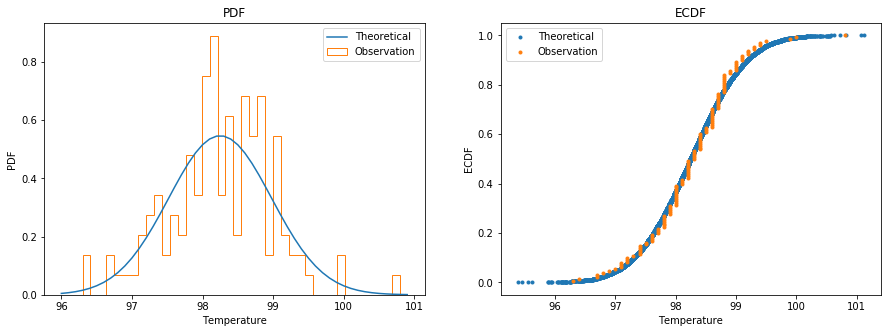

In [12]:
def ecdf(data):
    '''Returns the ecdf of the input data'''
    x = np.sort(data)
    y = np.arange(1, len(data)+1)/len(data)
    return x, y

f, axes = plt.subplots(1, 2, figsize=(15, 5))
# Plotting the PDF of input observation and the theoretical normal pdf with identical mean and std
x=np.arange(96, 101, 0.1)
y=1/np.sqrt(2*np.pi*std_t**2)*np.e**(-(x-mean_t)**2/(2*std_t**2))
axes[0].plot(x, y)
axes[0].hist(df.temperature, density=True, histtype='step', bins=40)
axes[0].set(title='PDF', xlabel='Temperature', ylabel='PDF')
axes[0].legend(('Theoretical', 'Observation'))

# Plotting the CDF of input observation and the theoretical normal pdf with identical mean and std
samples = np.random.normal(mean_t, std_t, size=10000)
x_theor, y_theor = ecdf(samples)
x_obs, y_obs = ecdf(df.temperature)
axes[1].plot(x_theor, y_theor, marker='.', linestyle='none')
axes[1].plot(x_obs, y_obs, marker='.', linestyle='none')
axes[1].set(title='ECDF', xlabel='Temperature', ylabel='ECDF')
axes[1].legend(('Theoretical', 'Observation'))

* Number of sample points = 130 (very low), due to which, we see binning bias. Hence, pdf plot is not the best way to check for normal distribution. 
* However, from the ECDF plot above, the curves seem to overlap reasonably well. So, the distribution could be normal 

## 2. Is the sample size large? Are the observations independent?

* Sample size = 130. Large enough for Normal approximation via Central Limit Theorem (CLT requires n>30)
* Observations are obtained from different people at different time instances and can be treated as independent

## 3. Is the true population mean really 98.6 degrees F?

### Bootstrap hypothesis test
**H0 = Null Hypothesis = True Mean Body Temperature = 98.6 degrees F**
* Use a one-sample test since we have 1 set of sample temperature data and 1 hypothesis value (98.6) that we are testing for
* Since our H0 indicates mean = 98.6, we first shift the observed data such that the mean is 98.6

In [13]:
def draw_bs_rep(data, func, size=1):
    '''Returns size number of bootstrap replicates defined by func using the samples from data '''
    bs_reps = np.empty(size)
    for i in range(size):
        bs_sample = np.random.choice(data, len(data))
        bs_reps[i] = func(bs_sample)
    return bs_reps

# one-sample bootstrap testing H0 that the mean body temperature = 98.6
mean_obs, mean_h0 = np.mean(df.temperature), 98.6
temperature_shifted = df.temperature - mean_obs + mean_h0  # Shifting such that mean of data = 98.6
temperature_bs_reps = draw_bs_rep(temperature_shifted, np.mean, 50000) 
p = np.sum(temperature_bs_reps<=mean_obs)/len(temperature_bs_reps)
print('Mean Observed = %.2f' %mean_obs)
print('p-value for the observed mean = %.3e' %p)

Mean Observed = 98.25
p-value for the observed mean = 0.000e+00


#### Confidence interval of the observed mean

In [14]:
# Obtaining various confidence intervals for the observed mean
temperature_bs_reps = draw_bs_rep(df.temperature, np.mean, 50000)
conf_interval = np.percentile(temperature_bs_reps, [0.05, 0.5, 2.5, 97.5, 99.5, 99.95])
print('Mean Observed = %.2f' %mean_obs)
print('95%%   Confidence interval of Observed Mean = [%.2f, %.2f]' %(conf_interval[2], conf_interval[3]))
print('99%%   Confidence interval of Observed Mean = [%.2f, %.2f]' %(conf_interval[1], conf_interval[4]))
print('99.9%% Confidence interval of Observed Mean = [%.2f, %.2f]' %(conf_interval[0], conf_interval[5]))

Mean Observed = 98.25
95%   Confidence interval of Observed Mean = [98.12, 98.37]
99%   Confidence interval of Observed Mean = [98.08, 98.41]
99.9% Confidence interval of Observed Mean = [98.04, 98.46]


#### Observations
* Very low p-value (close to 0) indicates that the observed mean is very unlikely (0-probability) if we were to assume H0 is true. This seems to indicate that our H0 hypothesis might be incorrect
* In line with the low-p value, the hypothesised temperature 98.6 is outside the 99.9% confidence interval of the observed mean, which again indicates that our H0 hypothesis might be incorrect
* Or there are might be other correlated factors that could have biased these observations? 

### Frequentist Statistical Testing
* Use a one-sample test since we have 1 set of sample temperature data and 1 hypothesis value (98.6) that we are testing for
* We do not have the true standard deviation, and hence we would use the standard deviation obtained from the observed data samples. Thus, it would make more sense to use t-statistic. However, since number of samples n>30 both z and t statistic should give more or less identical result

#### Analysis using Z-statistic
z-statistic = (mean observed - H0)/(std of temperature)
std of temperature ~ (std of observed data)/sqrt(n)

In [15]:
# Computing p-value of the observed data using z-statistics
zt_statistic = (mean_obs-mean_h0)/np.std(df.temperature)*np.sqrt(len(df.temperature))
print('Z statistic for the observed data assuming H0 = 98.6 = %.3f' %zt_statistic)
print('p-value using z-statistic table = Probability (z <= %.3f) = %.3e' %(zt_statistic, 2*st.norm.cdf(zt_statistic)))

Z statistic for the observed data assuming H0 = 98.6 = -5.476
p-value using z-statistic table = Probability (z <= -5.476) = 4.352e-08


#### Analysis using t-statistic
t-statisitic requires another input = degrees of freedom. The degrees of freedom for t-statistic = 130 (number of observations) 

In [16]:
# Computing p-value of the observed data using t-statistics
print('T statistic for the observed data assuming H0 = 98.6 = %.3f' %zt_statistic)
print('p-value using t-statistic table = Probability (t <= %.3f) = %.3e' %(zt_statistic, 2*st.t.cdf(zt_statistic, len(df.temperature))))

T statistic for the observed data assuming H0 = 98.6 = -5.476
p-value using t-statistic table = Probability (t <= -5.476) = 2.165e-07


## 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

Unless the entire data set is normally distributed, the smaller sample set wouldnt be normally distributed. Hence t-statistic would be the right one to use.  
**Problem Statement:** Using a sample size of 10, what is the p-value to obtain 98.6 degree F


In [17]:
sample_dataset = np.random.choice(df.temperature, 10) # Sample set of 10 temperatures

In [18]:
# Obtaining p-value from z-statistic and t-statistic table
zt_statistic = (mean_obs-mean_h0)/np.std(sample_dataset)*np.sqrt(len(sample_dataset))
print('T/Z statistic for the observed data assuming H0 = 98.6 = %.3f' %zt_statistic)
print('p-value using z-statistic table = Probability (z <= %.3f) = %.3f' %(zt_statistic, 2*st.norm.cdf(zt_statistic)))
print('p-value using t-statistic table = Probability (t <= %.3f) = %.3f' %(zt_statistic, 2*st.t.cdf(zt_statistic, len(sample_dataset))))

T/Z statistic for the observed data assuming H0 = 98.6 = -1.488
p-value using z-statistic table = Probability (z <= -1.488) = 0.137
p-value using t-statistic table = Probability (t <= -1.488) = 0.168


#### Observations
* Using smaller samples, our confidence value is low. Hence larger confidence interval. Thus, H0 hypothesis (true body temperature is 98.6) is true. 
* From the above, we can say that the z-statistic result tends to **under-estimate the confidence interval and p-value**. T-statistics compensates for the lower 'n' sample size. 

## 5. At what temperature should we consider someone's temperature to be "abnormal"?

### Bootstrap Method
* H0 hypothesis: The temberature is normal (or not abnormal)
* Use two-tailed comparison, i.e., both too low and too high temperature considered 'abnormal'. 
* Let us consider a significance level of 5% to categorize someone's temperature as 'abnormal', i.e., abnormal if Pr(The temperature occuring assuming H0) < 5%

#### Margin of Error and Confidence Interval

In [19]:
# Bootstrapping. Here each bootstrap replicates are individual user temperature (not the mean of 130 users)
temperature_bs_reps = np.empty(10000) # Generate bootstrap replicates from the provided data
for i in range(10000): 
    temperature_bs_reps[i] = np.random.choice(df.temperature, 1) # For a single individual
conf_interval = np.percentile(temperature_bs_reps, [2.5, 97.5])
margin_of_error = (conf_interval[1]-conf_interval[0])*0.5
print('Margin of Error (Bootstrap Method) = %.3f' %margin_of_error)
print('95%% Confidence interval of an Individuals Temperature (Bootstrap Method) = [%.2f, %.2f]' %(conf_interval[0], conf_interval[1]))

Margin of Error (Bootstrap Method) = 1.400
95% Confidence interval of an Individuals Temperature (Bootstrap Method) = [96.70, 99.50]


### Frequentist Method

Obtaining the 95% confidence interval for mean temperature.  
* confidence_interval = mean(data_set) +/- margin_of_error  
* where margin_of_error = z * std(data_set)/sqrt(num_samples_in_data_set)  
* where 'z' corresponds to the z-value required to obtain a 95% confidence level

In [20]:
# Frequentist method to obtain the abnormal temperature
z_value = st.norm.ppf(.975) # 95% confidence = 2.5% margin at either ends
margin_of_error = z_value*np.std(df.temperature)/1.0
conf_interval = [np.mean(df.temperature)-margin_of_error, np.mean(df.temperature)+margin_of_error]
print('Margin of Error (Frequentist Method) = %.3f' %margin_of_error)
print('95%% Confidence interval of an Individuals Temperature (Frequentist Method) = [%.2f, %.2f]' %(conf_interval[0], conf_interval[1]))

Margin of Error (Frequentist Method) = 1.431
95% Confidence interval of an Individuals Temperature (Frequentist Method) = [96.82, 99.68]


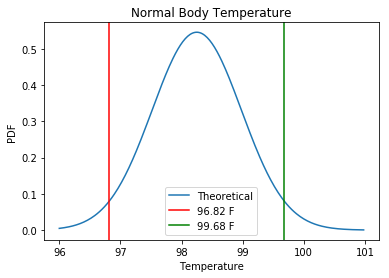

In [21]:
#Plot to show the normal body temperature range
mu, sigma = np.mean(df.temperature), np.std(df.temperature)
x=np.arange(96, 101, 0.02)
y=1/np.sqrt(2*np.pi*sigma**2)*np.e**(-(x-mu)**2/(2*sigma**2))
plt.plot(x, y)
plt.axvline(x=conf_interval[0], color='red')
plt.axvline(x=conf_interval[1], color='green')
plt.title('Normal Body Temperature')
plt.xlabel('Temperature')
plt.ylabel('PDF')
plt.legend(('Theoretical', "{0:.2f} F".format(conf_interval[0]), "{0:.2f} F".format(conf_interval[1])))
plt.show()

#### Observations
* We see a small difference in the values obtained by Bootstrap method and Frequentist Method. This is due to the granularity of the samples in the data. temperature_bs_reps contains only from the 130 values in the temperature array. And 2.5 and 97.5 percentile values are obtianed from temperature_bs_reps array. 
* The normal temperature range for an individual is the 95% confidence interval for an individual = [96.82,99.68] F

## 6. Is there a significant difference between males and females in normal temperature?

We saw early on that there was a difference in the mean temperatures between male and female. Is this difference significant? 
* H0: The mean temperature for male and female are same (Note: Nothing is claimed about the distribution. Hence, we have to sample male and female data separately)
* We will use the two-sample bootstrap test and two-sample t-test to validate the above hypothesis
    * Permutation method cannot be used since male and female samples cannot be combined (distributions might be different)

### Two-sample Bootstrap

In [22]:
# Two sample bootsrap. H0 = difference between male and female mean temperature are the same
temperature_m, temperature_f = df[df.gender=='M'].temperature, df[df.gender=='F'].temperature
mean_t, mean_m, mean_f = np.mean(df.temperature), np.mean(temperature_m), np.mean(temperature_f)
# Shifting the distribution so that both male and female data have same mean temperature
temperature_m_shifted = temperature_m - mean_m + mean_t 
temperature_f_shifted = temperature_f - mean_f + mean_t
mean_diff_obs = mean_f-mean_m 

temperature_bs_reps_m = draw_bs_rep(temperature_m_shifted, np.mean, 50000)
temperature_bs_reps_f = draw_bs_rep(temperature_f_shifted, np.mean, 50000)
temperature_bs_reps = temperature_bs_reps_f-temperature_bs_reps_m
p = np.sum(np.abs(temperature_bs_reps)>=np.abs(mean_diff_obs))/len(temperature_bs_reps)
print('Mean Observed = %.3f' %mean_diff_obs)
print('p-value for the observed mean = %.4f' %p)

Mean Observed = 0.289
p-value for the observed mean = 0.0226


### Two sample t-test (Frequentist Method)
* H0: The mean temperature for male and female are same, i.e., t_m - t_f = 0
* Goal is to compute the p-value for the observed data. If the p-value is low, then there is significant difference between men and women temperature
* Observed mean difference = mean_diff_obs = t_m - t_f = 0.289
* t-statistic = (mean_diff_obs - mean_h0)/std(temp_fm)* sqrt(n)
* Here distribution temp_fm = temp_f - temp_m and n = 130/2 = 65 

In [23]:
std_f_minus_m = np.sqrt(np.var(temperature_m)/len(temperature_m) + np.var(temperature_f)/len(temperature_f))
t_statistic = (mean_diff_obs - 0)/std_f_minus_m
print('T statistic for the observed data = %.3f' %t_statistic)
print('p-value using t-statistic table = Probability (t >= %.3f) = %.3f' %(t_statistic, 2*st.t.sf(t_statistic, len(df.temperature))))

T statistic for the observed data = 2.303
p-value using t-statistic table = Probability (t >= 2.303) = 0.023


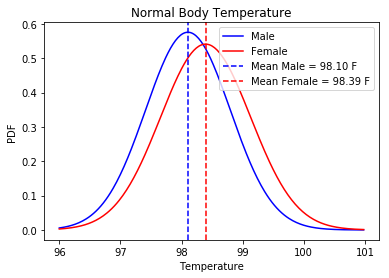

In [24]:
# Plot of female and male temperature as a normal distribution
mu_m, sigma_m = np.mean(temperature_m), np.std(temperature_m)
mu_f, sigma_f = np.mean(temperature_f), np.std(temperature_f)
x=np.arange(96, 101, 0.02)
y_m=1/np.sqrt(2*np.pi*sigma_m**2)*np.e**(-(x-mu_m)**2/(2*sigma_m**2))
y_f=1/np.sqrt(2*np.pi*sigma_f**2)*np.e**(-(x-mu_f)**2/(2*sigma_f**2))
plt.plot(x, y_m, color='blue', label='Male')
plt.plot(x, y_f, color='red', label='Female')
plt.axvline(x=mu_m, linestyle='--', color='blue', label='Mean Male = {0:.2f} F'.format(mu_m))
plt.axvline(x=mu_f, linestyle='--', color='red', label='Mean Female = {0:.2f} F'.format(mu_f))
plt.title('Normal Body Temperature')
plt.xlabel('Temperature')
plt.ylabel('PDF')
plt.legend()
#plt.legend(('Male', 'Female', 'Mean Male = {0:.2f} F'.format(mu_m), "Mean Female = {0:.2f} F".format(mu_f)))
plt.show()

### Observations
* From the above, it seems like the observed statistic (female temperature-male temperature >0.29 F) is very unlikely (1.1%) if we were to assume H0 (both male and female avg temperatures are identical)
* This leads us to conclude that the **H0 hypothesis is not true** and can be rejected. Average female body temperature is not equal to that of men